In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import shapely

# Function and class def|intions for defining LHC/Lake geometry
from GeometryHelpers import *

In [2]:
LHC_data = pd.read_parquet('Data/LHC_data.parquet')
Lake_data = pd.read_parquet('Data/Lake_data.parquet')

# Define the LHC circle
LHC = Circle(np.array(LHC_data.loc['Point4',['X','Y','Z']]),
             np.array(LHC_data.loc['LHCb',['X','Y','Z']]),
             np.array(LHC_data.loc['Point6',['X','Y','Z']])) # last entry can be Point 2 or 6

# Fix elevation of other LHC interaction points based on LHC circle definition
for k in list(LHC_data.index):
    elev,point = LHC.find_elevation(*np.array(LHC_data.loc[k,['Latitude','Longitude']]))
    LHC_data['Elevation'][k] = elev
    LHC_data.loc[k,['X','Y','Z']] = lat_long_to_xyz(*LHC_data.loc[k,['Latitude','Longitude','Elevation']])

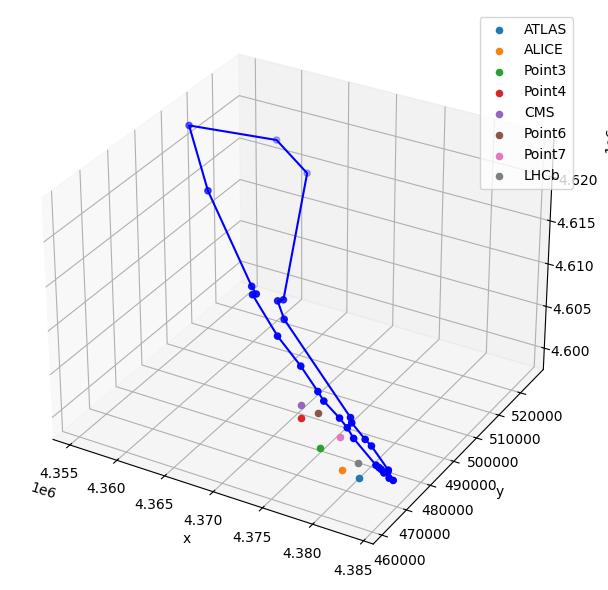

In [3]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(projection='3d')
for k in list(LHC_data.index):
    ax.scatter(*LHC_data.loc[k,['X','Y','Z']])
ax.scatter(*np.array(Lake_data[['X','Y','Z']]).transpose(),color='blue')
# for point in Lake_data[['X','Y','Z']]:
#     ax.scatter(*point,color='blue')
ax.plot(np.append(Lake_data['X'],Lake_data['X'][0]),
        np.append(Lake_data['Y'],Lake_data['Y'][0]),
        zs=np.append(Lake_data['Z'],Lake_data['Z'][0]),
        color='blue')
plt.legend(list(LHC_data.index))
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.show()

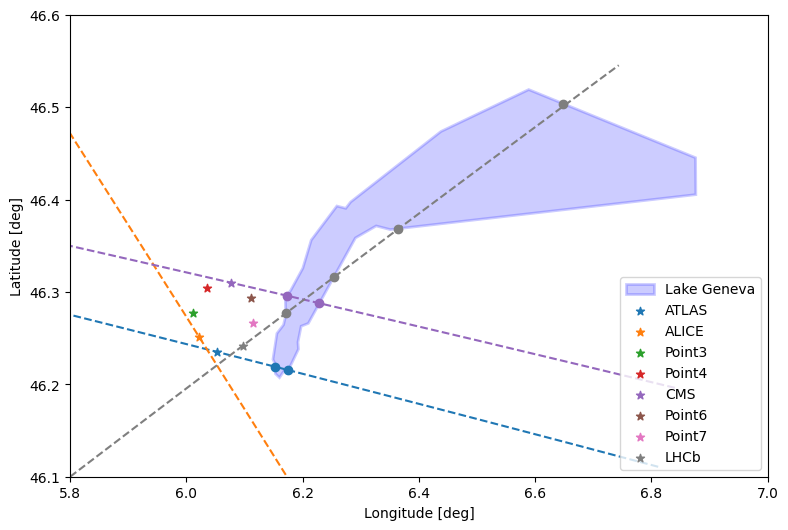

In [4]:
fig = plt.figure(figsize=(9,6))
plt.fill(list(Lake_data['Longitude']) + [Lake_data['Longitude'][0]],
         list(Lake_data['Latitude']) + [Lake_data['Latitude'][0]],
         color='blue',label='Lake Geneva',alpha=0.2,linewidth=2)
Lake_Crossings = {}
for k,color in zip(list(LHC_data.index),mcolors.TABLEAU_COLORS):
    Lake_Crossings[k] = []
    lines = plot_tangent_line_lat_long(LHC,
                                       np.array(LHC_data.loc[k,['X','Y','Z']]),
                                       np.array(LHC_data.loc[k,['CrossingOrientation','CrossingAngle']]),
                                       limit=1 if 'Point' in k else 60000)
    center, earth_points = lines[0] # all lines are essentially the same
    plt.plot([p[1] for p in earth_points],
            [p[0] for p in earth_points],color=color,ls='--')
    plt.scatter(center[1],
                center[0],
                marker='*',color=color,label=k)
    if 'Point' in k: continue # don't consider points without collisions
    int1,int2 = calculate_intersections_with_lake(LHC,
                                                np.array(LHC_data.loc[k,['X','Y','Z']]),
                                                np.array(LHC_data.loc[k,['CrossingOrientation','CrossingAngle']]),
                                                np.array(Lake_data[['Latitude','Longitude']]),
                                                limit=50000000)
    for intersections in (int1,int2):
        if(type(intersections) == shapely.geometry.MultiLineString):
            for intersection in intersections.geoms:
                for coord in list(intersection.coords):
                    Lake_Crossings[k].append(coord)
                    plt.scatter(coord[1],coord[0],color=color)
        else:
            for coord in list(intersections.coords):
                Lake_Crossings[k].append(coord)
                plt.scatter(coord[1],coord[0],color=color)
plt.xlabel('Longitude [deg]')
plt.ylabel('Latitude [deg]')
plt.legend(loc='lower right')
plt.xlim(5.8,7.0)
plt.ylim(46.1,46.6)
plt.show()

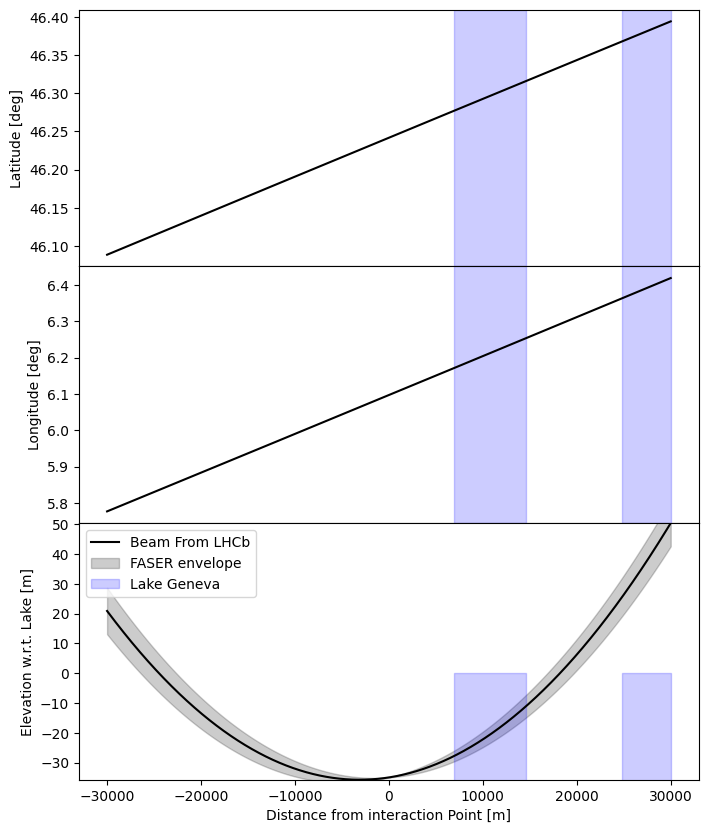

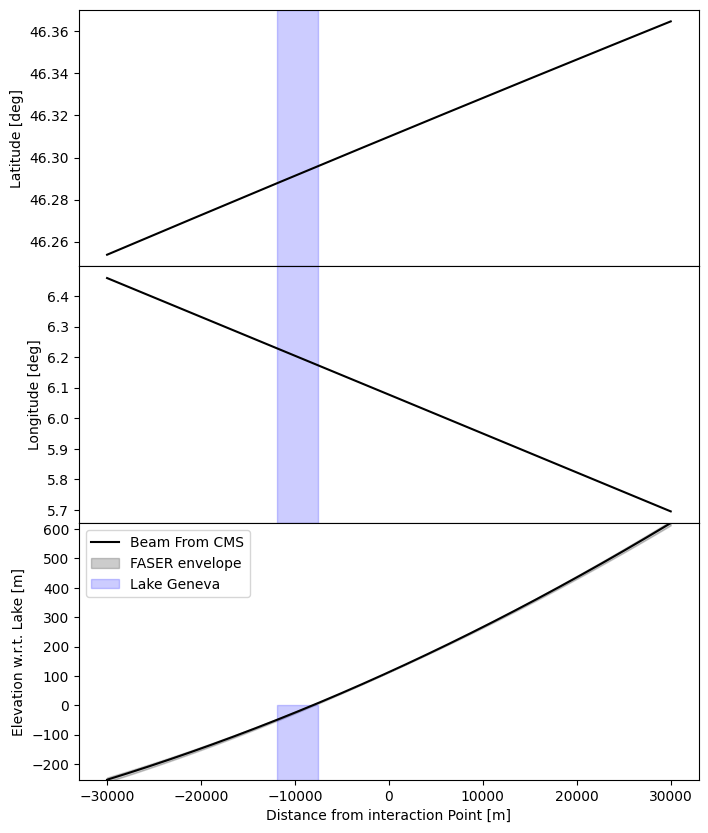

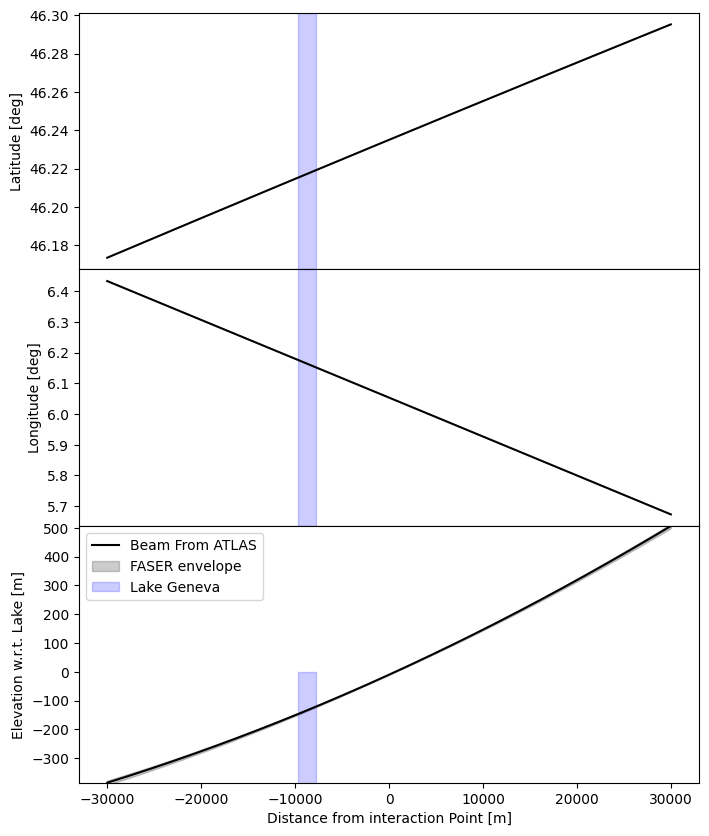

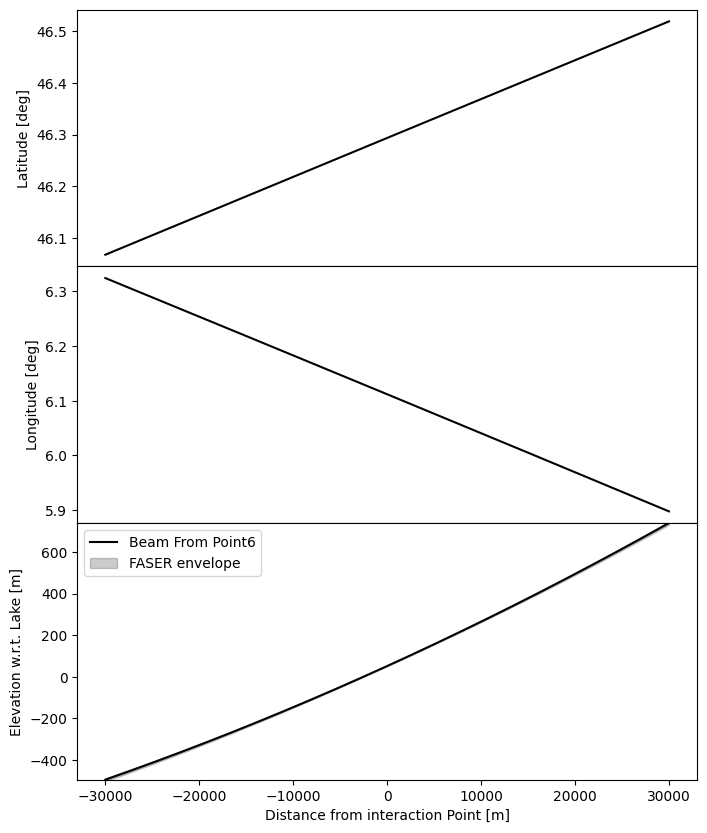

In [5]:
for k in ['LHCb','CMS','ATLAS','Point6']:
    plot_tangent_line(LHC,
                      np.array(LHC_data.loc[k,['X','Y','Z']]),
                      np.array(LHC_data.loc[k,['CrossingOrientation','CrossingAngle']]),
                      limit=30000,
                      Lake_Crossings=Lake_Crossings[k],
                      label='Beam From %s'%k)
    plt.show()

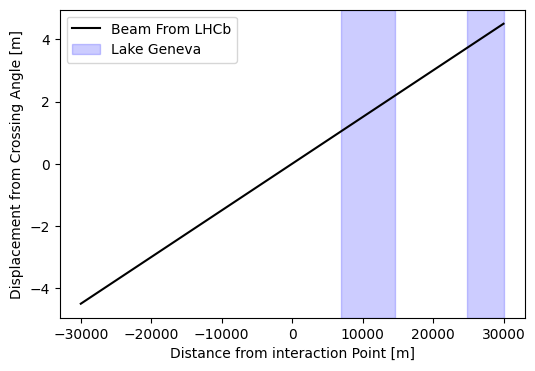

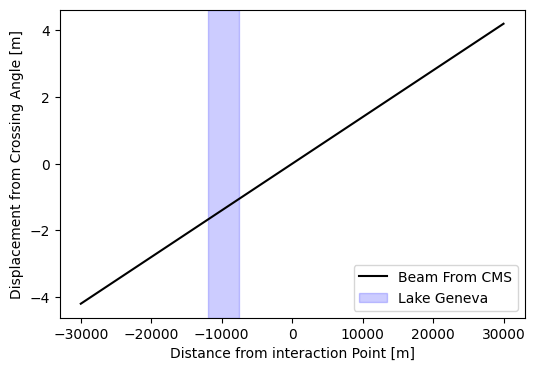

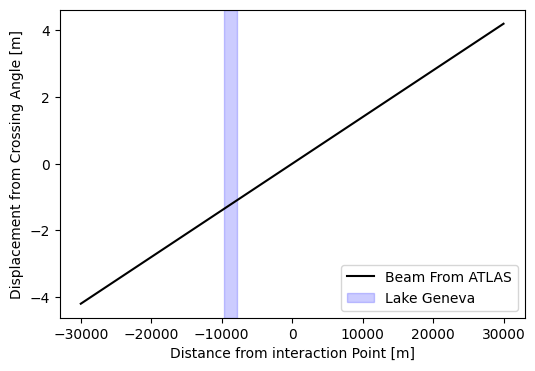

In [6]:
for k in ['LHCb','CMS','ATLAS']:
    plot_crossing_angle_impact(LHC,
                               np.array(LHC_data.loc[k,['X','Y','Z']]),
                               np.array(LHC_data.loc[k,['CrossingAngle']])/2.,
                               limit=30000,
                               Lake_Crossings=Lake_Crossings[k],
                               label='Beam From %s'%k)
    plt.show()